# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 
## Lecture 3 - Coding Environment Setup and review of `statsmodels`
###  Notebook B

**Harvard University**<br>
**Spring 2021**<br>
**Instructors:** Mark Glickman, Pavlos Protopapas, and Chris Tanner<br>
**Additional Instructor:** Eleni Kaxiras<br><BR>
*Content:* Eleni Kaxiras and Will Claybaugh

---

In [1]:
## RUN THIS CELL TO PROPERLY HIGHLIGHT THE EXERCISES
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2019-CS109B/master/content/styles/cs109.css").text
HTML(styles)

In [2]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline 

## Learning Goals

By the end of this lab, you should be able to:
* use `np.linalg.vander`
* use the weird R-style formulas in `statsmodels`
* practice least-squares regression in `statsmodels`

### Basis Functions

In our models we can use various types of functions as basis functions. Strictly speaking, in linear algebra where a basis for a subspace S of $\mathbb{R}^n$ is a set of vectors that spans S and is linearly independent. As a reminder, a set of vectors $\textbf{v}_1, \textbf{v}_2, ..., \textbf{v}_k$ are considered linearly independent if they cannot be written as a linear combination of each other, such that, if: $c_1\textbf{v}_1+c_2\textbf{v}_2+ ...+ c_k\textbf{v}_k = \textbf{0}$ then $c_1,c_2,...,c_k$ are all zero. <BR>
    
In data science where we have lots of imperfect data (with errors), as well as imperfect computers (with round-off errors), when we substitute their values into the matrices we almost always get column degeneracy, meaning, some of our columns become linear combinations of each other. Especially so if we use the monomial basis and go beyond ~5,6 degree of the polynomial. <BR>

Examples are:

- Monomials such as $x,x^2,x^4,x^5$ 
- Sigmoid/ReLU functions (neural networks)
- Fourier functions 
- Wavelets 
- Splines
    
The matrix produced when we substitute the values of our data into the basis functions is called the *design matrix*.

### Linear/Polynomial Regression

We will use the `diabetes` dataset.

Variables are:
- subject:   subject ID number
- age:       age diagnosed with diabetes
- acidity:   a measure of acidity called base deficit
Response:
- y:         natural log of serum C-peptide concentration

*Original source is Sockett et al. (1987) mentioned in Hastie and Tibshirani's book 
"Generalized Additive Models".*




Reading the data in Pandas:

In [3]:
diab = pd.read_csv("data/diabetes.csv")
diab.head()

,subject,age,acidity,y
0,1,5.2,-8.1,4.8
1,2,8.8,-16.1,4.1
2,3,10.5,-0.9,5.2
3,4,10.6,-7.8,5.5
4,5,10.4,-29.0,5.0


### Create the design matrix for a fictitious dataset
Let's keep just the `age` feature and create some columns of our own. Let's see how good this matrix is before we create the design matrix.

In [4]:
diab_age = diab[['age']].copy()
diab_age['age2'] = diab_age.apply(lambda row: row['age']**2, axis=1)
diab_age['random'] = np.random.normal(0,1,len(diab_age)) 
diab_age['same'] = diab_age['age']
diab_age.head()

,age,age2,random,same
0,5.2,27.04,0.983557,5.2
1,8.8,77.44,-1.167022,8.8
2,10.5,110.25,1.167812,10.5
3,10.6,112.36,1.667912,10.6
4,10.4,108.16,1.616005,10.4


In [5]:
A = diab_age.to_numpy(copy=True)
A[:5]

array([[  5.2       ,  27.04      ,   0.98355687,   5.2       ],
       [  8.8       ,  77.44      ,  -1.16702237,   8.8       ],
       [ 10.5       , 110.25      ,   1.16781157,  10.5       ],
       [ 10.6       , 112.36      ,   1.66791156,  10.6       ],
       [ 10.4       , 108.16      ,   1.61600545,  10.4       ]])

Let's check if the columns of A are linearly independent by using some linear algebra methods from `numpy.linalg` and `sympy`. 

In [6]:
from numpy.linalg import matrix_rank
matrix_rank(A)

3

In [7]:
# check out which rows are linearly independent
import sympy
_, inds = sympy.Matrix(A).T.rref() 
inds

(0, 1, 2)

In [8]:
np.linalg.cond(A)

7.913850862345827e+16

### Create the design matrix for `age` using a polynomial basis
Let's keep just the `age` feature again and create the design matrix using a polynomial of degree `n`. First we will use the basic `numpy` formula `vander()`.

In [9]:
vand = np.vander(diab_age.age, 2, increasing=True)
vand[:3], vand.shape

(array([[ 1. ,  5.2],
        [ 1. ,  8.8],
        [ 1. , 10.5]]),
 (43, 2))

In [10]:
## To our point why the Vandermonde matrix is usually ill-conditioned, 
## find the condition number of this matrix
np.linalg.cond(vand), matrix_rank(vand)

(24.709088478926237, 2)

<div class="exercise"><b>Exercise</b>: Vandermonde matrix</div><BR>
Change the degree of the polynomial and comment on what happens to the condition and rank of the matrix.

In [11]:
vand = np.vander(diab_age.age, 8, increasing=True)
vand[:3], vand.shape

(array([[1.00000000e+00, 5.20000000e+00, 2.70400000e+01, 1.40608000e+02,
         7.31161600e+02, 3.80204032e+03, 1.97706097e+04, 1.02807170e+05],
        [1.00000000e+00, 8.80000000e+00, 7.74400000e+01, 6.81472000e+02,
         5.99695360e+03, 5.27731917e+04, 4.64404087e+05, 4.08675596e+06],
        [1.00000000e+00, 1.05000000e+01, 1.10250000e+02, 1.15762500e+03,
         1.21550625e+04, 1.27628156e+05, 1.34009564e+06, 1.40710042e+07]]),
 (43, 8))

In [12]:
## To our point why the Vandermonde matrix is usually ill-conditioned, 
## find the condition number of this matrix
np.linalg.cond(vand), matrix_rank(vand)

(4207821284.7228603, 8)

### Linear/Polynomial regression with statsmodels. 

As you remember from 109a, we have two tools for Linear Regression:
- `statsmodels` [https://www.statsmodels.org/stable/regression.html](https://www.statsmodels.org/stable/regression.html), and 
- `sklearn`[https://scikit-learn.org/stable/index.html](https://scikit-learn.org/stable/index.html)

Previously, in this notebook, we worked from a vector of target values and a design matrix we built ourself. In 109a we used e.g. `sklearn`'s PolynomialFeatures to build the matrix. Now we will look at `statsmodels` which allows users to fit statistical models using R-style **formulas**. They build the target value and design matrix for you. 

**Note:** Categorical features (e.g. let's say we had a categorical feature called Region, are designated by `C(Region)`), polynomial features (e.g. age) are entered as `np.power(age, n)` where `n` is the degree of the polynomial **OR** `np.vander(age, n, increasing=True)`.

```
# Example: if our target variable is 'Lottery', while 'Region' is a categorical predictor and all the others are numerical:
df = dta.data[['Lottery', 'Literacy', 'Wealth', 'Region']]

formula='Lottery ~ Literacy + Wealth + C(Region) + Literacy * Wealth'
```

For more on these formulas see:

- https://www.statsmodels.org/stable/examples/notebooks/generated/formulas.html
- https://patsy.readthedocs.io/en/latest/overview.html 

In [13]:
import statsmodels.formula.api as smf

model1 = smf.ols('y ~ age', data=diab)
fit1_lm = model1.fit()

Let's build a dataframe to predict values on (sometimes this is just the test or validation set). Very useful for making pretty plots of the model predictions - predict for TONS of values, not just whatever's in the training set.

In [14]:
x_pred = np.linspace(0.5,20,100)

predict_df = pd.DataFrame(data={"age":x_pred})
predict_df.head()

,age
0,0.500000
1,0.696970
2,0.893939
3,1.090909
4,1.287879


Use `get_prediction(<data>).summary_frame()` to get the model's prediction (and error bars!)

In [15]:
prediction_output = fit1_lm.get_prediction(predict_df).summary_frame()
prediction_output.head()

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,4.037574,0.233301,3.566412,4.508736,2.650278,5.424870
1,4.053940,0.228886,3.591696,4.516184,2.669647,5.438232
2,4.070305,0.224489,3.616940,4.523670,2.688952,5.451658
3,4.086671,0.220113,3.642143,4.531198,2.708193,5.465149
4,4.103036,0.215759,3.667302,4.538770,2.727369,5.478703


Plot the data, the fitted model, the **confidence intervals**, and the *prediction intervals*. For more on how `statsmodels` calculates these intervals see: https://www.statsmodels.org/stable/_modules/statsmodels/regression/_prediction.html

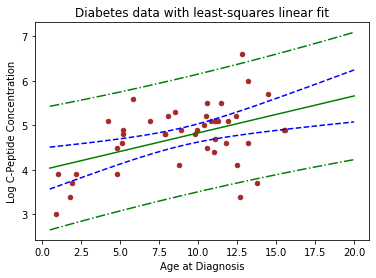

In [16]:
ax1 = diab.plot.scatter(x='age',y='y',c='brown',title="Diabetes data with least-squares linear fit")
ax1.set_xlabel("Age at Diagnosis")
ax1.set_ylabel("Log C-Peptide Concentration")

ax1.plot(predict_df.age, prediction_output['mean'],color="green")
ax1.plot(predict_df.age, prediction_output['mean_ci_lower'], color="blue",linestyle="dashed")
ax1.plot(predict_df.age, prediction_output['mean_ci_upper'], color="blue",linestyle="dashed")
ax1.plot(predict_df.age, prediction_output['obs_ci_lower'], color="green",linestyle="dashdot")
ax1.plot(predict_df.age, prediction_output['obs_ci_upper'], color="green",linestyle="dashdot");

<div class="exercise"><b>Breakout Room Exercise</b></div>

- Fit a 3rd degree polynomial model to predict `y` using only `age` and
- Plot the model and its confidence intervals.
- Change the degree of your polynomial and see what happens to the fitted curve.
- Does our model have an intercept? *Note*: we can discover the existence or not of an intercept in our model by running:
```
model_name.params
```

In [18]:
# your answer here

model2 = smf.ols(formula = 'y ~ np.vander(age, 4, increasing=True)-1', data=diab, missing='drop')
fit2_lm = model2.fit()

In [19]:
x_pred = np.linspace(0.5,20,100)

predict_df = pd.DataFrame(data={"age":x_pred})
predict_df.head()

,age
0,0.500000
1,0.696970
2,0.893939
3,1.090909
4,1.287879


In [20]:
prediction_output = fit2_lm.get_prediction(predict_df).summary_frame()
prediction_output.head()

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,3.057129,0.405478,2.236972,3.877285,1.599098,4.515159
1,3.173396,0.370403,2.424185,3.922608,1.754061,4.592732
2,3.285013,0.338413,2.600508,3.969517,1.898743,4.671282
3,3.392068,0.309541,2.765962,4.018174,2.033685,4.750451
4,3.494653,0.283823,2.920567,4.068739,2.159449,4.829857


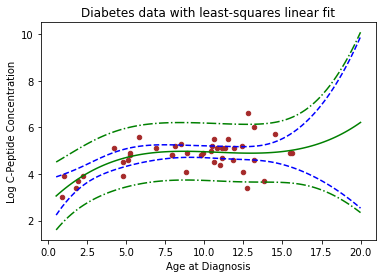

In [21]:
ax2 = diab.plot.scatter(x='age',y='y',c='brown',title="Diabetes data with least-squares linear fit")
ax2.set_xlabel("Age at Diagnosis")
ax2.set_ylabel("Log C-Peptide Concentration")

ax2.plot(predict_df.age, prediction_output['mean'],color="green")
ax2.plot(predict_df.age, prediction_output['mean_ci_lower'], color="blue",linestyle="dashed")
ax2.plot(predict_df.age, prediction_output['mean_ci_upper'], color="blue",linestyle="dashed")
ax2.plot(predict_df.age, prediction_output['obs_ci_lower'], color="green",linestyle="dashdot")
ax2.plot(predict_df.age, prediction_output['obs_ci_upper'], color="green",linestyle="dashdot");

In [22]:
# solution 


<div class="discussion"><b>Vandermonde matrix in formulas</b></div>
    
It's easier to build higher order polynomials using `np.vandrer()`.

In [24]:
formula = "y ~ np.vander(age, 6, increasing=True) -1" 
fit3_lm = smf.ols(formula=formula, data=diab).fit()

In [25]:
fit3_lm.params

np.vander(age, 6, increasing=True)[0]    3.147753
np.vander(age, 6, increasing=True)[1]    0.130248
np.vander(age, 6, increasing=True)[2]    0.136034
np.vander(age, 6, increasing=True)[3]   -0.028749
np.vander(age, 6, increasing=True)[4]    0.002064
np.vander(age, 6, increasing=True)[5]   -0.000050
dtype: float64

In [26]:
## To our point why the Vandermonde matrix is usually ill-conditioned, 
# find the condition number of this matrix
np.linalg.cond(np.vander(predict_df.age, 6, increasing=True))

11539278.6863067

In [27]:
# solution 
poly_predictions = fit3_lm.get_prediction(predict_df).summary_frame()
poly_predictions.head()

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,3.243420,0.734767,1.754641,4.732198,1.308481,5.178358
1,3.295358,0.568205,2.144066,4.446650,1.606277,4.984440
2,3.353648,0.438495,2.465173,4.242123,1.831507,4.875789
3,3.417256,0.347322,2.713515,4.120997,1.995013,4.839499
4,3.485217,0.295584,2.886306,4.084128,2.111820,4.858614


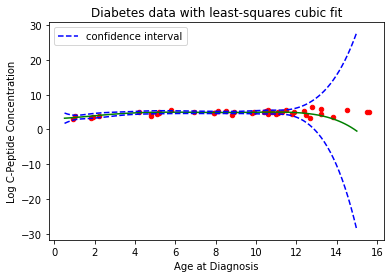

In [28]:
# solution
x_pred = np.linspace(0.5,15,100)
predict_df = pd.DataFrame(data={"age":x_pred})

ax2 = diab.plot.scatter(x='age',y='y',c='Red',title="Diabetes data with least-squares cubic fit")
ax2.set_xlabel("Age at Diagnosis")
ax2.set_ylabel("Log C-Peptide Concentration")

ax2.plot(predict_df.age, poly_predictions['mean'],color="green")
ax2.plot(predict_df.age, poly_predictions['mean_ci_lower'], color="blue",linestyle="dashed", label='confidence interval')
ax2.plot(predict_df.age, poly_predictions['mean_ci_upper'], color="blue",linestyle="dashed");
ax2.legend();

<div class="discussion"><b>Discussion</b></div>

#### QR decomposition (**Beyond the scope of this class**)

As you know, to find the parameters of our model, we may try to solve the so-called *normal equations*, which, written in matrix form, are:<BR>
\begin{equation}
    (\boldsymbol{A^T}\cdot \boldsymbol{A}) \cdot \boldsymbol{b} = \boldsymbol{A} \cdot \boldsymbol{y}
\end{equation}
    
The direct solution is $\hat{\boldsymbol{b}}=(\boldsymbol{A}^T\cdot \boldsymbol{A})^{-1}\cdot \boldsymbol{A}^T \cdot \boldsymbol{y}$
    
Solving the least-squares problem directly via the normal equations is susceptible to roundoff error when the condition of the matrix $\boldsymbol{A}$ is large. An alternative technique involves QR decomposition (details in any good linear algebra book). `statsmodels` lets you use this technique via a parameter in the `.fit`:
```
   .fit(method='qr') 
```
    


#### Let's try with QR now

In [35]:
formula = "y ~ np.vander(age, 6, increasing=True) -1" 
fit3_lm = smf.ols(formula=formula, data=diab).fit(method='qr')

In [34]:
fit3_lm.params

np.vander(age, 6, increasing=True)[0]   NaN
np.vander(age, 6, increasing=True)[1]   NaN
np.vander(age, 6, increasing=True)[2]   NaN
np.vander(age, 6, increasing=True)[3]   NaN
np.vander(age, 6, increasing=True)[4]   NaN
np.vander(age, 6, increasing=True)[5]   NaN
dtype: float64

In [31]:
# solution 
poly_predictions = fit3_lm.get_prediction(predict_df).summary_frame()
poly_predictions.head()

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN


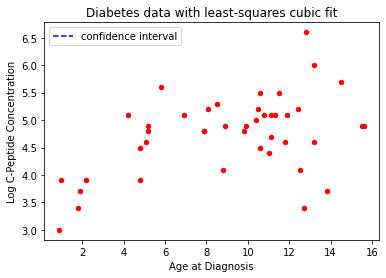

In [32]:
# solution
ax2 = diab.plot.scatter(x='age',y='y',c='Red',title="Diabetes data with least-squares cubic fit")
ax2.set_xlabel("Age at Diagnosis")
ax2.set_ylabel("Log C-Peptide Concentration")

ax2.plot(predict_df.age, poly_predictions['mean'],color="green")
ax2.plot(predict_df.age, poly_predictions['mean_ci_lower'], color="blue",linestyle="dashed", label='confidence interval')
ax2.plot(predict_df.age, poly_predictions['mean_ci_upper'], color="blue",linestyle="dashed");
ax2.legend();